**SECCIÓ 3: Mètodes espectrals**  
**Problema 3.7: Equacions de Navier-Stokes**

En aquest repositori es presenta la simulació emprada per les equacions de Navier-Stokes amb condicions de contorn periòdiques, **Problema 3.7**, que correspon a la **Secció 3** del treball.


In [24]:
import numpy as np
from math import pi
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.animation as animation
from IPython.display import Video, display
from matplotlib.animation import PillowWriter
from matplotlib.gridspec import GridSpec

params = {
    'legend.fontsize': 15,
    'legend.loc': 'best',
    'figure.figsize': (14, 5),
    'lines.markerfacecolor': 'none',
    'axes.labelsize': 20,
    'axes.titlesize': 20,
    'xtick.labelsize': 20, 
    'ytick.labelsize': 20, 
    'grid.alpha': 0.6,
    'text.usetex': True,
    'font.family': 'serif',
    'font.serif': ['Computer Modern Roman'],
    'text.latex.preamble': r'\usepackage{amsmath}'
}

plt.rcParams.update(params)

In [25]:
# --------------------------
# Funcions de comprovacio: 
# --------------------------

#Conservacio de la massa 
def Checkup_mass(Lx, Nx, Ly, Ny, u, v):
    dx = Lx / Nx
    dy = Ly / Ny 

    kx = np.fft.fftfreq(Nx, d=(Lx / Nx)) * (2 * np.pi)
    ky = np.fft.fftfreq(Ny, d=(Ly / Ny)) * (2 * np.pi)
    KX, KY = np.meshgrid(kx, ky)

    ux_fft = np.fft.ifft2(1j * KX * np.fft.fft2(u)).real
    vy_fft = np.fft.ifft2(1j * KY * np.fft.fft2(v)).real

    ux = (np.roll(u, shift=-1, axis = 1) - np.roll(u, shift= 1, axis = 1)) / (2*dx)
    vy = (np.roll(v, shift=-1, axis = 0) - np.roll(v, shift=1, axis = 0)) / (2*dy)

    print("Error divergencia (FFT): "+ str(np.max(np.array(abs(ux_fft + vy_fft)))))
    print("Error volum divergencia (FFT): " + str(sum(sum(abs(ux_fft + vy_fft))) * (Lx / Nx) * (Ly / Ny) ))
    print("Error divergencia (Elem. Finits): "+ str(np.max(np.array(abs(ux + vy)))))
    print("Error volum divergencia (Elem. Finits): " + str(sum(sum(abs(ux + vy))) * (Lx / Nx) * (Ly / Ny) ))

# Conservacio del moment lineal 
def Checkup_momentum(Lx, Nx, Ly, Ny, u_list, v_list, Re, dt):     
    dx = Lx / Nx
    dy = Ly / Ny 

    kx = np.fft.fftfreq(Nx, d=(Lx / Nx)) * (2 * np.pi)
    ky = np.fft.fftfreq(Ny, d=(Ly / Ny)) * (2 * np.pi)
    KX, KY = np.meshgrid(kx, ky)

    u = u_list[-2]
    v = v_list[-2]

    u_hat = np.fft.fft2(u)
    v_hat = np.fft.fft2(v)

    ux = (np.roll(u, shift=-1, axis = 1) - np.roll(u, shift= 1, axis = 1)) / (2*dx)
    uy = (np.roll(u, shift=-1, axis = 0) - np.roll(u, shift=1, axis = 0)) / (2*dy)
    uxx = (np.roll(u, shift=-1, axis = 1) + np.roll(u, shift=1, axis = 1) - 2 * u) / (dx**2)
    uyy = (np.roll(u, shift=-1, axis = 0) + np.roll(u, shift=1, axis = 0) - 2 * u) / (dy**2)

    vx = (np.roll(v, shift=-1, axis = 1) - np.roll(v, shift=1, axis = 1)) / (2*dx)
    vy = (np.roll(v, shift=-1, axis = 0) - np.roll(v, shift=1, axis = 0)) / (2*dy)
    vxx = (np.roll(v, shift=-1, axis = 1) + np.roll(v, shift=1, axis = 1) - 2 * v) / (dx**2)
    vyy = (np.roll(v, shift=-1, axis = 0) + np.roll(v, shift=1, axis = 0) - 2 * v) / (dy**2)

    u_u_x_hat = 1/2 * 1j * KX * np.fft.fft2(u*u)
    v_v_y_hat = 1/2 * 1j * KY * np.fft.fft2(v*v)

    u_y_hat = 1j * KY * u_hat
    v_u_y = np.fft.ifft2(v_hat).real * np.fft.ifft2(u_y_hat).real
    v_u_y_hat = np.fft.fft2(v_u_y)

    v_x_hat = 1j * KX * v_hat
    u_v_x = np.fft.ifft2(u_hat).real * np.fft.ifft2(v_x_hat).real
    u_v_x_hat = np.fft.fft2(u_v_x)

    f_u = - (u_u_x_hat + v_u_y_hat)
    f_v = - (v_v_y_hat + u_v_x_hat)

    denominator = KX**2 + KY**2 + 10**(-12)
    gradPx = np.fft.ifft2((KX * f_u + KY * f_v) / denominator * KX)
    gradPy = np.fft.ifft2((KX * f_u + KY * f_v) / denominator * KY) 

    delta_u = uxx + uyy
    delta_v = vxx + vyy

    conv_u = u * ux + v * uy
    conv_v = u * vx + v * vy

    u_t = (u_list[-1] - u_list[-3])/(2*dt)
    v_t = (v_list[-1] - v_list[-3])/(2*dt)

    Momentum_error_x = u_t + conv_u - ( - gradPx + 1/Re * delta_u )
    Momentum_error_y = v_t + conv_v - ( - gradPy + 1/Re * delta_v )

    print("----------")
    print("Error maxim moment en x:" + str(np.max(np.array(abs(Momentum_error_x)))))
    print("Error maxim volum moment en x:" + str(sum(sum(abs(Momentum_error_x))) *  ((Lx / Nx) * (Ly / Ny)) ))
    print("Error maxim moment en y:" + str(np.max(np.array(abs(Momentum_error_y)))))
    print("Error maxim volum moment en y:" + str(sum(sum(abs(Momentum_error_y))) * ((Lx / Nx) * (Ly / Ny)) ))
    print("----------")

In [26]:
# --------------------------
# Parametres
# --------------------------
Lx, Ly = 2*np.pi, 2* np.pi   #domini
Nx, Ny = 256, 256  #Numero de harmonics
Re = 1000 #Numero de Reynolds
nu = 1/ Re         
dt = 0.01 #Pas de temps
T = 200*dt #Temps de simulacio
timesteps = int(T / dt) 

x = np.linspace(0, Lx, Nx, endpoint= False)
y = np.linspace(0, Ly, Ny, endpoint = False)
X, Y = np.meshgrid(x, y)

kx = np.fft.fftfreq(Nx, d=(Lx / Nx)) * (2 * np.pi)
ky = np.fft.fftfreq(Ny, d=(Ly / Ny)) * (2 * np.pi)
KX, KY = np.meshgrid(kx, ky)

#Condicio inicial (donada per una funcio de corrent) 
f =  np.sin(2*X)*np.cos(X)*np.sin(2*Y)**2  
fx = np.fft.ifft2(1j * KX * np.fft.fft2(f))
fy = np.fft.ifft2(1j * KY * np.fft.fft2(f))

u = -fy
v = fx

u_hat = np.fft.fft2(u)
v_hat = np.fft.fft2(v)    

u_list = []
v_list = []


def nonlinear_term_uv_2D(u_hat, v_hat, Nx, Ny):
    Mx, My = (3 * Nx) // 2, (3 * Ny) // 2  

    u_hat_pad = np.zeros((Mx, My), dtype=complex)
    v_hat_pad = np.zeros((Mx, My), dtype=complex)

    u_hat_pad[:Nx//2, :Ny//2] = u_hat[:Nx//2, :Ny//2]  
    u_hat_pad[-Nx//2:, :Ny//2] = u_hat[-Nx//2:, :Ny//2]
    u_hat_pad[:Nx//2, -Ny//2:] = u_hat[:Nx//2, -Ny//2:]  
    u_hat_pad[-Nx//2:, -Ny//2:] = u_hat[-Nx//2:, -Ny//2:]  


    v_hat_pad[:Nx//2, :Ny//2] = v_hat[:Nx//2, :Ny//2]
    v_hat_pad[-Nx//2:, :Ny//2] = v_hat[-Nx//2:, :Ny//2]
    v_hat_pad[:Nx//2, -Ny//2:] = v_hat[:Nx//2, -Ny//2:]
    v_hat_pad[-Nx//2:, -Ny//2:] = v_hat[-Nx//2:, -Ny//2:]

    u_pad = np.fft.ifft2(u_hat_pad).real * (Mx / Nx) * (My / Ny)
    v_pad = np.fft.ifft2(v_hat_pad).real * (Mx / Nx) * (My / Ny)

    nonlinear_term_pad = np.fft.fft2(u_pad * v_pad) * (Nx / Mx) * (Ny / My)

    nonlinear_term = np.zeros((Nx, Ny), dtype=complex)
    nonlinear_term[:Nx//2, :Ny//2] = nonlinear_term_pad[:Nx//2, :Ny//2]
    nonlinear_term[-Nx//2:, :Ny//2] = nonlinear_term_pad[-Nx//2:, :Ny//2]
    nonlinear_term[:Nx//2, -Ny//2:] = nonlinear_term_pad[:Nx//2, -Ny//2:]
    nonlinear_term[-Nx//2:, -Ny//2:] = nonlinear_term_pad[-Nx//2:, -Ny//2:]

    return nonlinear_term

def nonlinear_term_KKT_padded(u_vector_hat, KX, KY):
    u_hat = u_vector_hat[0]
    v_hat = u_vector_hat[1]

    u_u_x_hat = 1/2 * 1j * KX * nonlinear_term_uv_2D(u_hat, u_hat, Nx, Ny)   
    v_v_y_hat = 1/2 * 1j * KY * nonlinear_term_uv_2D(v_hat, v_hat, Nx, Ny) 

    u_y_hat = 1j * KY * u_hat
    v_u_y_hat = nonlinear_term_uv_2D(v_hat, u_y_hat, Nx, Ny) 

    v_x_hat = 1j * KX * v_hat
    u_v_x_hat = nonlinear_term_uv_2D(u_hat, v_x_hat, Nx, Ny) 

    f_u = - (u_u_x_hat + v_u_y_hat)
    f_v = - (v_v_y_hat + u_v_x_hat)

    denominator = KX**2 + KY**2 + 10**(-12)

    return np.array([(f_u - (KX * f_u + KY * f_v) / denominator * KX), (f_v - (KX * f_u + KY * f_v) / denominator * KY)])

for k in range(timesteps):
    #Part lineal
    u_hat_m = u_hat * np.exp(- nu * (KX**2 + KY**2) * dt)  
    v_hat_m = v_hat * np.exp(- nu * (KX**2 + KY**2) * dt)         
        
    #Part no lineal
    k1 = nonlinear_term_KKT_padded(np.array([u_hat, v_hat]), KX, KY)
    k2 = nonlinear_term_KKT_padded(np.array([u_hat, v_hat]) + 1/2 * dt * k1, KX, KY)
    k3 = nonlinear_term_KKT_padded(np.array([u_hat, v_hat]) + 1/2 * dt * k2, KX, KY)
    k4 = nonlinear_term_KKT_padded(np.array([u_hat, v_hat] + dt * k3), KX, KY)

    u_hat = u_hat_m + dt / 6 * (k1 + 2*k2 + 2*k3 + k4)[0]
    v_hat = v_hat_m + dt / 6 * (k1 + 2*k2 + 2*k3 + k4)[1]

    if k > (timesteps - 10):
        u = np.real(np.fft.ifft2(u_hat))
        v = np.real(np.fft.ifft2(v_hat))
        u_list.append(u)
        v_list.append(v)

    k = k+1

print("Valor max velocitat" + str(np.max(np.array(abs(u)))))
print("Volum max velocitat: "+ str(sum(sum(abs(u)))))
print('------')
Checkup_momentum(Lx, Nx, Ly, Ny, u_list, v_list, Re, dt)
print('------')
Checkup_mass(Lx, Nx, Ly, Ny, u, v)

Valor max velocitat0.3545986997053882
Volum max velocitat: 6675.674515653097
------
----------
Error maxim moment en x:0.0340518800896694
Error maxim volum moment en x:0.11330095110053767
Error maxim moment en y:0.04595850845748569
Error maxim volum moment en y:0.20113085512948092
----------
------
Error divergencia (FFT): 0.0006981760872338816
Error volum divergencia (FFT): 0.009904131582012147
Error divergencia (Elem. Finits): 0.10672605685876868
Error volum divergencia (Elem. Finits): 0.33136199511393744


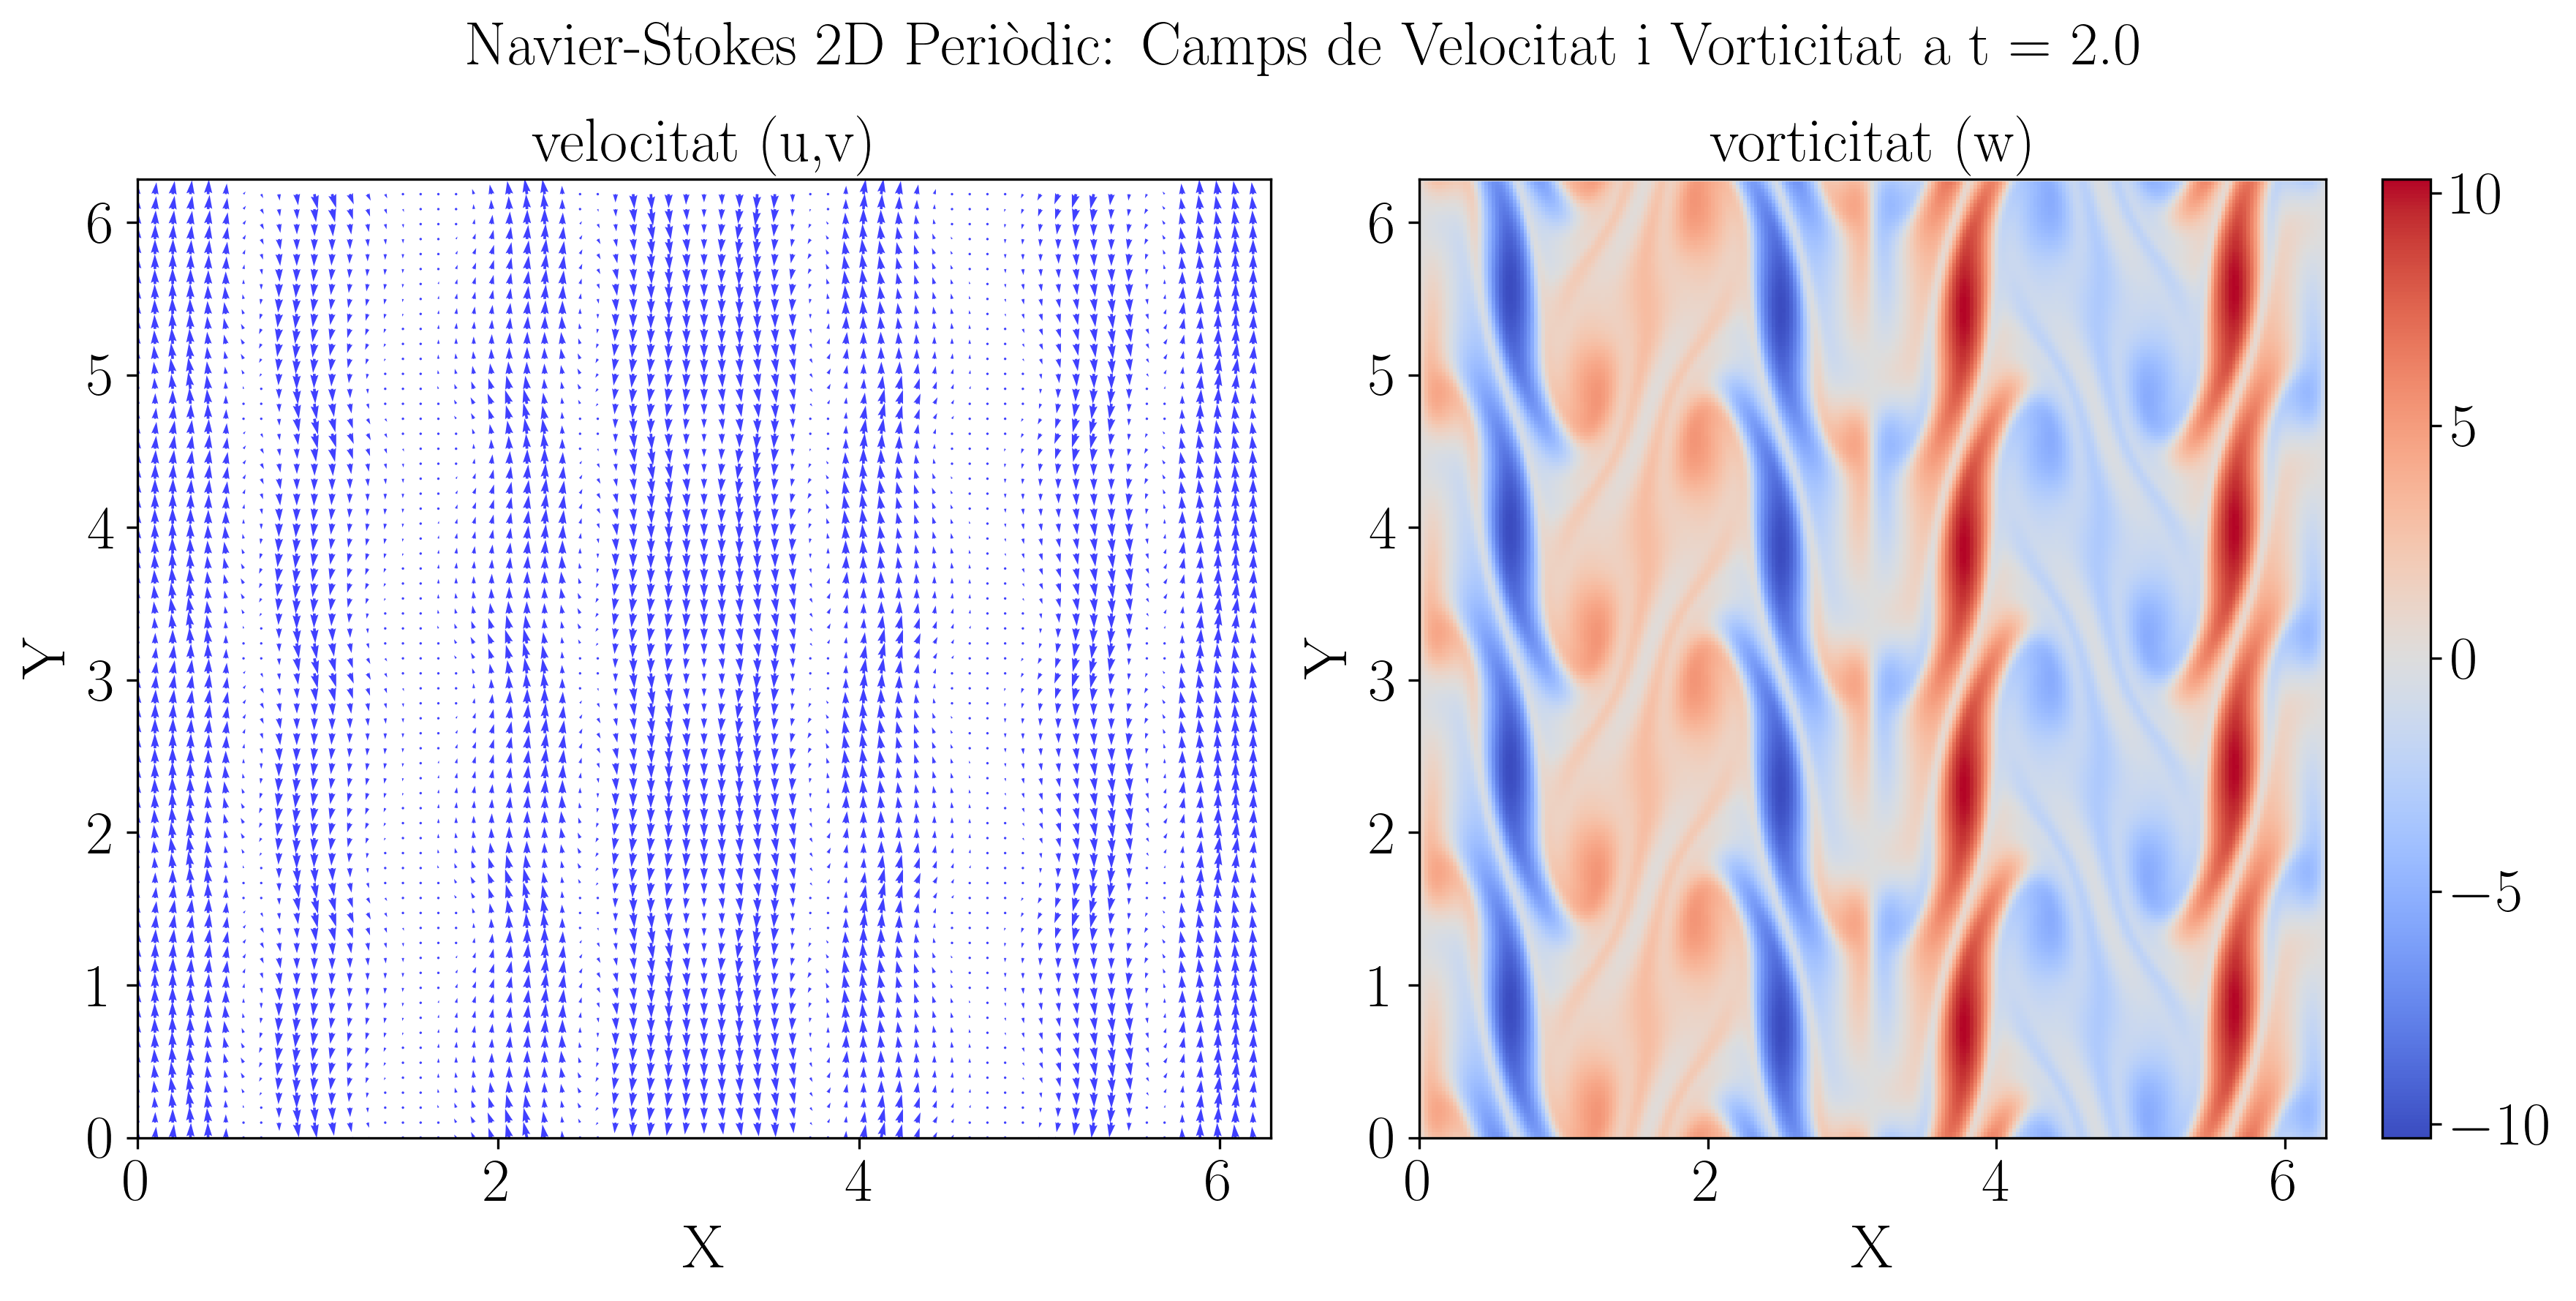

In [27]:
# --------------------------
# Dibuix
# --------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 6), dpi = 300)
fig.suptitle(f'Navier-Stokes 2D Periòdic: Camps de Velocitat i Vorticitat a t = {T}', fontsize=20, fontweight='bold')

step = 4  # int(Nx / 32)

# Magnitud de la velocitat
axes[0].quiver(X[::step, ::step], Y[::step, ::step], u[::step, ::step], v[::step, ::step], color='b', scale_units = 'xy', alpha=0.75)
axes[0].set_xlabel('X')
axes[0].set_ylabel('Y')
axes[0].set_title('velocitat (u,v)', fontsize = 20)
axes[0].set_xlim([0, Lx])
axes[0].set_ylim([0, Ly])

vx = np.fft.ifft2(1j * KX * np.fft.fft2(v))
uy = np.fft.ifft2(1j * KY * np.fft.fft2(u))
w = vx - uy

pcm = axes[1].pcolormesh(X, Y, np.real(w), cmap='coolwarm', shading='auto')
axes[1].set_xlabel('X')
axes[1].set_ylabel('Y')
axes[1].set_title('vorticitat (w)', fontsize = 20)
axes[1].set_xlim([0, Lx])
axes[1].set_ylim([0, Ly])

fig.colorbar(pcm, ax=axes[1])

plt.tight_layout()
plt.show()

In [28]:
# --------------------------
# Figura 6 (carrega de dades)
# --------------------------

# Mallat de punts
X, Y = np.meshgrid(np.linspace(0, 2*np.pi, 256), np.linspace(0, 2*np.pi, 256))
KX = np.fft.fftfreq(256, d=(2*np.pi/256)) * 2*np.pi
KY = np.fft.fftfreq(256, d=(2*np.pi/256)) * 2*np.pi
KX, KY = np.meshgrid(KX, KY)

# Condicio inicial perturbada
epsilon = 0.1
k = 2
u_initial = np.cos(k * Y) + epsilon * np.sin(k * X) * np.sin(k * Y)
v_initial = epsilon * np.cos(k * X) * np.cos(k * Y)

# Dades obtingudes de la simulacio anterior
u_turb = np.load('Data/NS_2D_u_dt_0.005_t_5.0_turbolentRe_5000N_256.npy')
v_turb = np.load('Data/NS_2D_v_dt_0.005_t_5.0_turbolentRe_5000N_256.npy')
u_laminar = np.load('Data/NS_2D_u_dt_0.005_t_5_turbolentRe_30N_256.npy')
v_laminar = np.load('Data/NS_2D_u_dt_0.005_t_5_turbolentRe_30N_256.npy')

# vorticitat
def compute_vorticity(u, v):
    uy = np.fft.ifft2(1j * KY * np.fft.fft2(u))
    vx = np.fft.ifft2(1j * KX * np.fft.fft2(v))
    return np.real(vx - uy)

w_initial = compute_vorticity(u_initial, v_initial)
w_laminar = compute_vorticity(u_laminar[-1], v_laminar[-1])
w_turb = compute_vorticity(u_turb[-1], v_turb[-1])

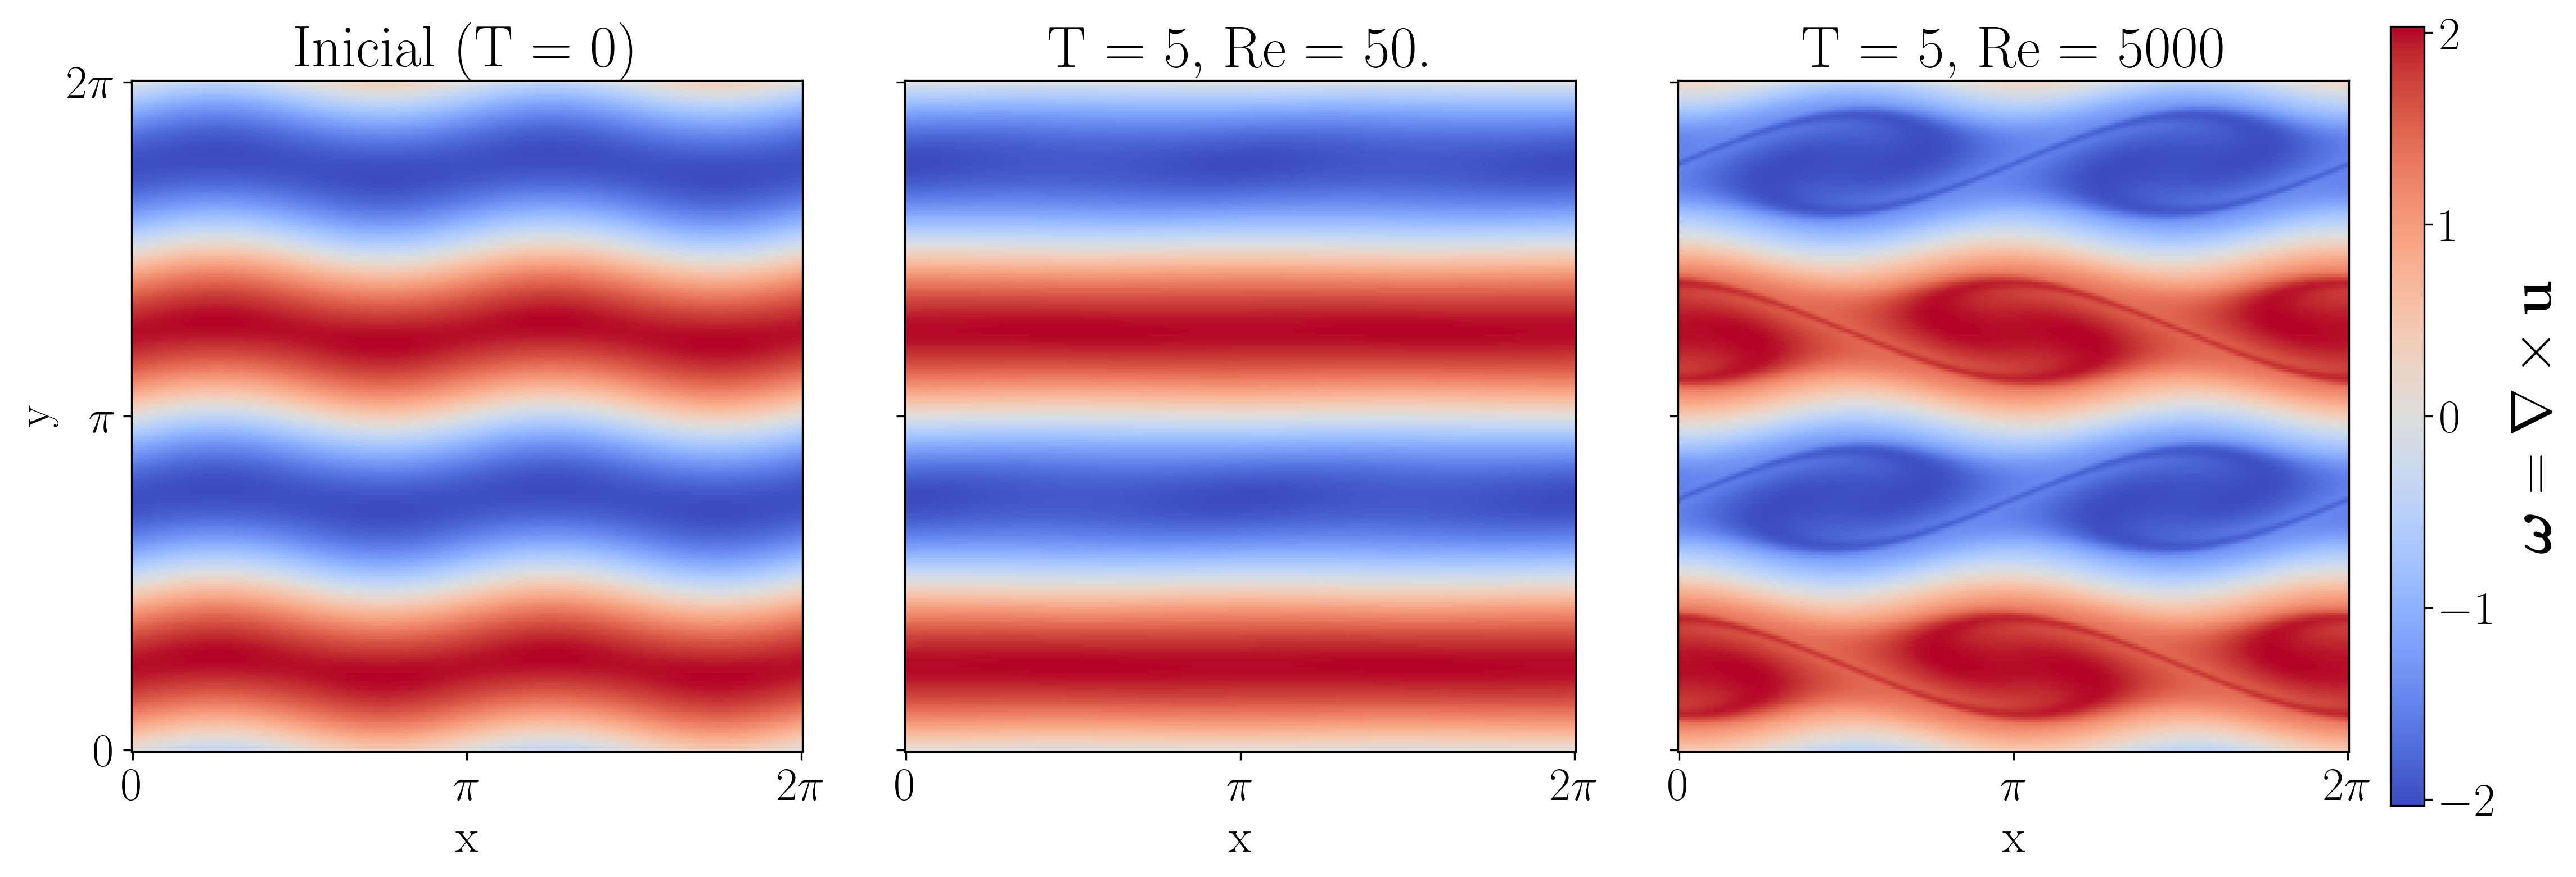

In [29]:
# --------------------------
# Figura 6 (dibuix)
# --------------------------

fig = plt.figure(figsize=(18, 6), dpi=300)
gs = GridSpec(1, 4, figure=fig, width_ratios=[1, 1, 1, 0.05], wspace=0.2)
xticks = [0, np.pi, 2 * np.pi]
xtick_labels = ['0', r'$\pi$', r'$2\pi$']

ax0 = fig.add_subplot(gs[0])
im0 = ax0.pcolormesh(X, Y, w_initial, cmap='coolwarm', shading='auto')
ax0.set_title('Inicial (T = 0)', fontsize=25)
ax0.set_xlabel('x')
ax0.set_ylabel('y')
ax0.set_aspect('equal')
ax0.set_xticks(xticks)
ax0.set_xticklabels(xtick_labels)
ax0.set_yticks(xticks)
ax0.set_yticklabels(xtick_labels)

ax1 = fig.add_subplot(gs[1])
im1 = ax1.pcolormesh(X, Y, w_laminar, cmap='coolwarm', shading='auto')
ax1.set_title('T = 5, Re = 50.', fontsize=25)
ax1.set_xlabel('x')
ax1.set_aspect('equal')
ax1.set_xticks(xticks)
ax1.set_xticklabels(xtick_labels)
ax1.set_yticks(xticks)
ax1.set_yticklabels([])  

ax2 = fig.add_subplot(gs[2])
im2 = ax2.pcolormesh(X, Y, w_turb, cmap='coolwarm', shading='auto')
ax2.set_title('T = 5, Re = 5000', fontsize=25)
ax2.set_xlabel('x')
ax2.set_aspect('equal')
ax2.set_xticks(xticks)
ax2.set_xticklabels(xtick_labels)
ax2.set_yticks(xticks)
ax2.set_yticklabels([]) 

cax = fig.add_subplot(gs[3])
cbar = fig.colorbar(im2, cax=cax, shrink=0.8)
cbar.set_label(r'$\boldsymbol{\omega} = \nabla \times \mathbf{u}$', fontsize=25, weight='bold')

pos = cax.get_position()
new_pos = [pos.x0 - 0.02, pos.y0, pos.width, pos.height]
cax.set_position(new_pos)

plt.show()